In [15]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from uedge import *
from uedge.hdf5 import *
#import plotmesh as pm
from uetools import Case
from uedge.gridue import write_gridue
from Forthon import gchange

# Create Case from YAML

In [95]:
c = Case('reconverged_FINAL_v12_p3.93_n2.38_imp4e2_dp0.06_kep0.06_kip0.0226_last_ii2.hdf5')
# c = Case('reconverged3_v12_p1.45_n2.38_imp8e3_dp0.06_kep0.06_kip0.0226_last_ii2.hdf5')
# c = Case('input_v12_dif.yaml')
print("dif_use, kye_use, kyi_use around SOL:", bbb.dif_use[28, :, 0][1], bbb.kye_use[28, :][1], bbb.kyi_use[28, :][1])
#if bbb.dif_use[30, :, 0][1] == c_dif and bbb.kye_use[30, :][1] == c_kye and bbb.kyi_use[30, :][1] == c_kyi:
   # pass
#else:
    #print(f'Diffusivities or chi values not matching!', file=sys.stderr)
# fnorm for final=1.65e+00

Restoring case from HDF5 file:
  Rate dirs read from .uedgerc
  Grid read from .../jupyter/MANTA_final_baseline/reconverged_FINAL_v12_p3.93_n2.38_imp4e2_dp0.06_kep0.06_kip0.0226_last_ii2.hdf5
  User-specified diffusivities read from HDF5 file ".../jupyter/MANTA_final_baseline/reconverged_FINAL_v12_p3.93_n2.38_imp4e2_dp0.06_kep0.06_kip0.0226_last_ii2.hdf5"
UETOOLS-style save successfully restored from .../jupyter/MANTA_final_baseline/reconverged_FINAL_v12_p3.93_n2.38_imp4e2_dp0.06_kep0.06_kip0.0226_last_ii2.hdf5
*** For isimpon=2, set afracs, not afrac ***

*** UEDGE arrays populated: Case appears converged ***
fnrm without preconditioning: 1.65e+00

dif_use, kye_use, kyi_use around SOL: 0.059 0.059 0.0221


In [36]:
bbb.afracs

array([[0.04, 0.04, 0.04, ..., 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, ..., 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, ..., 0.04, 0.04, 0.04],
       ...,
       [0.04, 0.04, 0.04, ..., 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, ..., 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, ..., 0.04, 0.04, 0.04]])

In [66]:
c.populate()
print("dif_use, kye_use, kyi_use around SOL:", bbb.dif_use[30, :, 0][1], bbb.kye_use[30, :][1], bbb.kyi_use[30, :][1])

*** For isimpon=2, set afracs, not afrac ***

*** UEDGE arrays populated: WARNING, case NOT converged ***
fnrm without preconditioning: 5.67e+07

dif_use, kye_use, kyi_use around SOL: 0.059 0.059 0.0221


<Figure size 640x480 with 0 Axes>

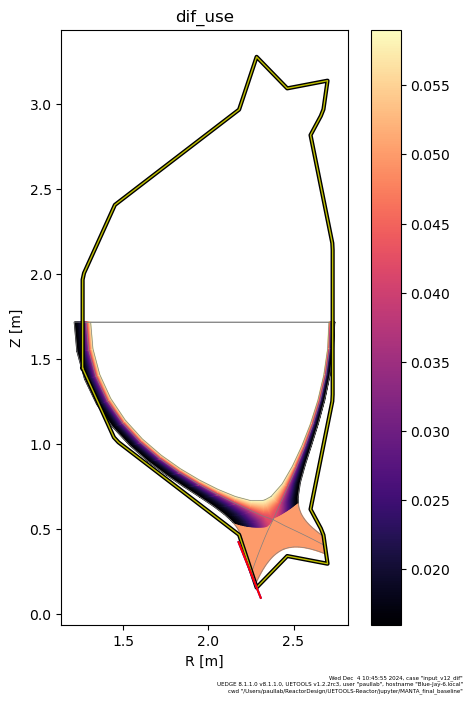

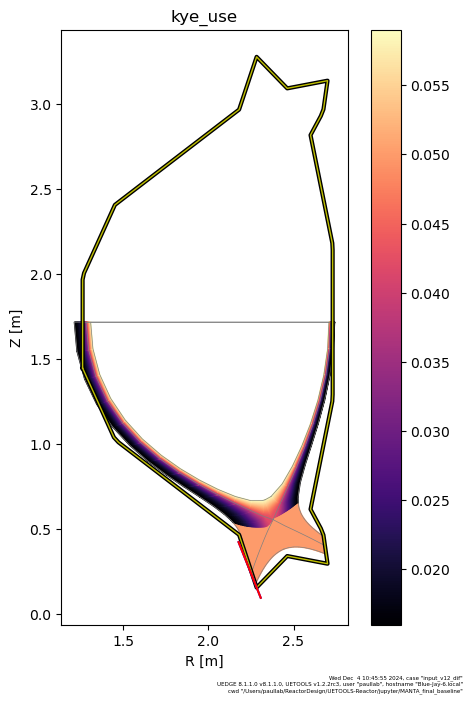

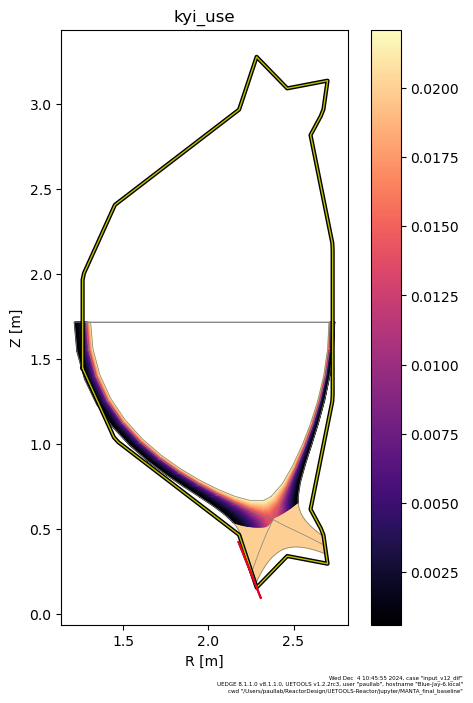

In [39]:
c_dif = 0.05
c_kye = 0.05
c_kyi = 0.02

prof_d = [0.06, 0.059, 0.058, 0.057, 0.056, 0.055, 0.054, 0.053, 0.052, 0.051, 
 0.05, 0.049, 0.048, 0.047, 0.046, 0.045, 0.044, 0.043, 0.042, 0.041, 
 0.04, 0.039, 0.038, 0.037, 0.036, 0.035, 0.034, 0.033, 0.032, 0.031, 
 0.03, 0.029, 0.028, 0.027, 0.026, 0.025, 0.024, 0.023, 0.022, 0.021, 
 0.02, 0.019, 0.018, 0.017, 0.016, 0.015]
prof_e = [0.06, 0.059, 0.058, 0.057, 0.056, 0.055, 0.054, 0.053, 0.052, 0.051, 
 0.05, 0.049, 0.048, 0.047, 0.046, 0.045, 0.044, 0.043, 0.042, 0.041, 
 0.04, 0.039, 0.038, 0.037, 0.036, 0.035, 0.034, 0.033, 0.032, 0.031, 
 0.03, 0.029, 0.028, 0.027, 0.026, 0.025, 0.024, 0.023, 0.022, 0.021, 
 0.02, 0.019, 0.018, 0.017, 0.016, 0.015]
prof_i = [0.0226, 0.0221, 0.0216, 0.0211, 0.0206, 0.0201, 0.0196, 0.0191, 0.0186, 0.0181, 
 0.0176, 0.0171, 0.0166, 0.0161, 0.0156, 0.0151, 0.0146, 0.0141, 0.0136, 0.0131, 
 0.0126, 0.0121, 0.0116, 0.0111, 0.0106, 0.0101, 0.0096, 0.0091, 0.0086, 0.0081, 
 0.0076, 0.0071, 0.0066, 0.0061, 0.0056, 0.0051, 0.0046, 0.0041, 0.0036, 0.0031, 
 0.0026, 0.0021, 0.0016, 0.0011, 0.0006, 0.0001]

#divertor region temporary for plotting, reset to 0.5 at the end of cell
bbb.dif_use[1:17, :, 0] = c_dif
bbb.dif_use[41:65, :, 0] = c_dif
bbb.kye_use[1:17, :] = c_kye
bbb.kye_use[41:65, :] = c_kye
bbb.kyi_use[1:17, :] = c_kyi
bbb.kyi_use[41:65, :] = c_kyi

bbb.dif_use[30,:,0] = prof_d
bbb.dif_use[29,:,0] = prof_d
bbb.dif_use[28,:,0] = prof_d
bbb.dif_use[27,:,0] = prof_d
bbb.dif_use[26,:,0] = prof_d
bbb.dif_use[25,:,0] = prof_d
bbb.dif_use[24,:,0] = prof_d
bbb.dif_use[23,:,0] = prof_d
bbb.dif_use[22,:,0] = prof_d
bbb.dif_use[21,:,0] = prof_d
bbb.dif_use[20,:,0] = prof_d
bbb.dif_use[19,:,0] = prof_d
bbb.dif_use[18,:,0] = prof_d
bbb.dif_use[17,:,0] = prof_d
bbb.dif_use[31,:,0] = prof_d
bbb.dif_use[32,:,0] = prof_d
bbb.dif_use[33,:,0] = prof_d
bbb.dif_use[34,:,0] = prof_d
bbb.dif_use[35,:,0] = prof_d
bbb.dif_use[36,:,0] = prof_d
bbb.dif_use[37,:,0] = prof_d
bbb.dif_use[38,:,0] = prof_d
bbb.dif_use[39,:,0] = prof_d
bbb.dif_use[40,:,0] = prof_d

bbb.kye_use[30,:] = prof_e
bbb.kye_use[29,:] = prof_e
bbb.kye_use[28,:] = prof_e
bbb.kye_use[27,:] = prof_e
bbb.kye_use[26,:] = prof_e
bbb.kye_use[25,:] = prof_e
bbb.kye_use[24,:] = prof_e
bbb.kye_use[23,:] = prof_e
bbb.kye_use[22,:] = prof_e
bbb.kye_use[21,:] = prof_e
bbb.kye_use[20,:] = prof_e
bbb.kye_use[19,:] = prof_e
bbb.kye_use[18,:] = prof_e
bbb.kye_use[17,:] = prof_e
bbb.kye_use[31,:] = prof_e
bbb.kye_use[32,:] = prof_e
bbb.kye_use[33,:] = prof_e
bbb.kye_use[34,:] = prof_e
bbb.kye_use[35,:] = prof_e
bbb.kye_use[36,:] = prof_e
bbb.kye_use[37,:] = prof_e
bbb.kye_use[38,:] = prof_e
bbb.kye_use[39,:] = prof_e
bbb.kye_use[40,:] = prof_e

bbb.kyi_use[30,:] = prof_i
bbb.kyi_use[29,:] = prof_i
bbb.kyi_use[28,:] = prof_i
bbb.kyi_use[27,:] = prof_i
bbb.kyi_use[26,:] = prof_i
bbb.kyi_use[25,:] = prof_i
bbb.kyi_use[24,:] = prof_i
bbb.kyi_use[23,:] = prof_i
bbb.kyi_use[22,:] = prof_i
bbb.kyi_use[21,:] = prof_i
bbb.kyi_use[20,:] = prof_i
bbb.kyi_use[19,:] = prof_i
bbb.kyi_use[18,:] = prof_i
bbb.kyi_use[17,:] = prof_i
bbb.kyi_use[31,:] = prof_i
bbb.kyi_use[32,:] = prof_i
bbb.kyi_use[33,:] = prof_i
bbb.kyi_use[34,:] = prof_i
bbb.kyi_use[35,:] = prof_i
bbb.kyi_use[36,:] = prof_i
bbb.kyi_use[37,:] = prof_i
bbb.kyi_use[38,:] = prof_i
bbb.kyi_use[39,:] = prof_i
bbb.kyi_use[40,:] = prof_i

plt.figure()
c.plot.mesh(bbb.dif_use[:,:,0])
plt.title('dif_use')

c.plot.mesh(bbb.kye_use[:,:])
plt.title('kye_use')

c.plot.mesh(bbb.kyi_use[:,:])
plt.title('kyi_use')

plt.show()

bbb.dif_use[1:17, :, 0] = c_dif
bbb.dif_use[41:65, :, 0] = c_dif
bbb.kye_use[1:17, :] = c_kye
bbb.kye_use[41:65, :] = c_kye
bbb.kyi_use[1:17, :] = c_kyi
bbb.kyi_use[41:65, :] = c_kyi

#indexing first index from 1 starts at the inner plate moving upward with index number, starting at
#Core boundary indicies: HFS: 17-30, LFS: 31-40
#kye biases heat outer plate, dif is more inner plate and has more of an effecto on midplane temps

#for ix in range(com.ixpt1[0]+1,com.ixpt2[0]: bbb.dif_use[ix,:,0]= [0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5]
#len bbb.dif_use[#,:,0] = 46

#for ix in range(com.ixpt1[0] + 1, com.ixpt2[0]):
    #print(bbb.dif_use[ix,:,0])
#kye,i decrease makes wall heat go down and decreases lambda, dif decrease increases wall heat again


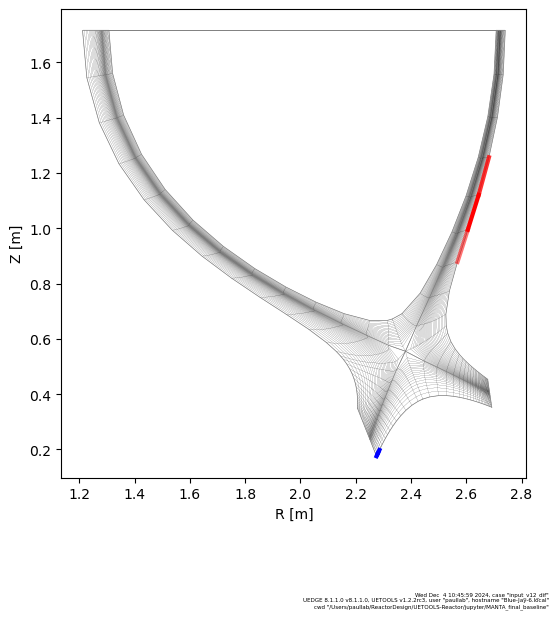

In [40]:
from plot_sinksource import plot_sinksource
plot_sinksource(c)

# Converge

In [16]:
bbb.afracs = 7.5e-3

In [7]:
bbb.afracs

array([[0.0075, 0.0075, 0.0075, ..., 0.0075, 0.0075, 0.0075],
       [0.0075, 0.0075, 0.0075, ..., 0.0075, 0.0075, 0.0075],
       [0.0075, 0.0075, 0.0075, ..., 0.0075, 0.0075, 0.0075],
       ...,
       [0.0075, 0.0075, 0.0075, ..., 0.0075, 0.0075, 0.0075],
       [0.0075, 0.0075, 0.0075, ..., 0.0075, 0.0075, 0.0075],
       [0.0075, 0.0075, 0.0075, ..., 0.0075, 0.0075, 0.0075]])

In [14]:
bbb.pcoree = 1.45e6
bbb.pcorei = 1.45e6
bbb.pcoree,bbb.pcorei

(1450000.0, 1450000.0)

In [15]:
c.populate()

*** For isimpon=2, set afracs, not afrac ***

*** UEDGE arrays populated: WARNING, case NOT converged ***
fnrm without preconditioning: 4.75e+04



In [ ]:
import subprocess
bbb.isbcwdt=0
proc = subprocess.Popen(['caffeinate', "-d", "-u", "-i", "-s"])

try:
    c.converge(savefname='reconverged3_v12_p1.4_n2.38_imp7.5e3_dp0.06_kep0.06_kip0.0226', dtreal=1e-10)
    os.system("printf '\7'") #macos plays sound after converging
finally:
    # Terminate caffeinate
    proc.terminate()

Requested save-path ../solutions not found, writing to cwd!
*----------------------------------------------------------*
 Need to take initial step with Jacobian; trying to do here 
*----------------------------------------------------------*
*** For isimpon=2, set afracs, not afrac ***
 Reading grid data from /Users/paullab/ReactorDesign/UETOOLS-Reactor/jupyter/MANTA_final_baseline/reconverged3_v12_p1.5_n2.38_imp7.5e3_dp0.06_kep0.06_kip0.0226_last_ii2.hdf5.hdf5
 Grid data read successfully:
     file name:   /Users/paullab/ReactorDesign/UETOOLS-Reactor/jupyter/MANTA_final_baseline/reconverged3_v12_p1.5_n2.38_imp7.5e3_dp0.06_kep0.06_kip0.0226_last_ii2.hdf5.hdf5
     run-ID:      TokaMaker:                                                  
  Updating Jacobian, npe =                      1
 iter=    0 fnrm=     0.1245433600052437E-01 nfe=      1
  Updating Jacobian, npe =                      2
 iter=    1 fnrm=     0.2173300393589850E-03 nfe=      4
 iter=    2 fnrm=     0.8642533190466

In [9]:
import subprocess
proc = subprocess.Popen(['caffeinate', "-d", "-u", "-i", "-s"])

try:
    c.continuation_solve('afracs', 1e-2, savedir='impu_up', dtreal=1e-10, ftol=1e-2)
    os.system("printf '\7'") #macos plays sound after converging
finally:
    # Terminate caffeinate
    proc.terminate()

*----------------------------------------------------------*
 Need to take initial step with Jacobian; trying to do here 
*----------------------------------------------------------*
    -Variable(s) being solved:
                                        - afracs
    -Progress                             0.000%
    -Advancing by                         0.100%
    -Steps to target at current delta:    1000

*** For isimpon=2, set afracs, not afrac ***
 Reading grid data from /Users/paullab/ReactorDesign/UETOOLS-Reactor/jupyter/MANTA_final_baseline/reconverged_v12_p1.0_n2.38_imp2e3_dp0.06_kep0.06_kip0.0226_last_ii2.hdf5.hdf5
 Grid data read successfully:
     file name:   /Users/paullab/ReactorDesign/UETOOLS-Reactor/jupyter/MANTA_final_baseline/reconverged_v12_p1.0_n2.38_imp2e3_dp0.06_kep0.06_kip0.0226_last_ii2.hdf5.hdf5
     run-ID:      TokaMaker:                                                  
  Updating Jacobian, npe =                      1
===== MAIN LOOP 1/7 ===== iter=    0 fnrm

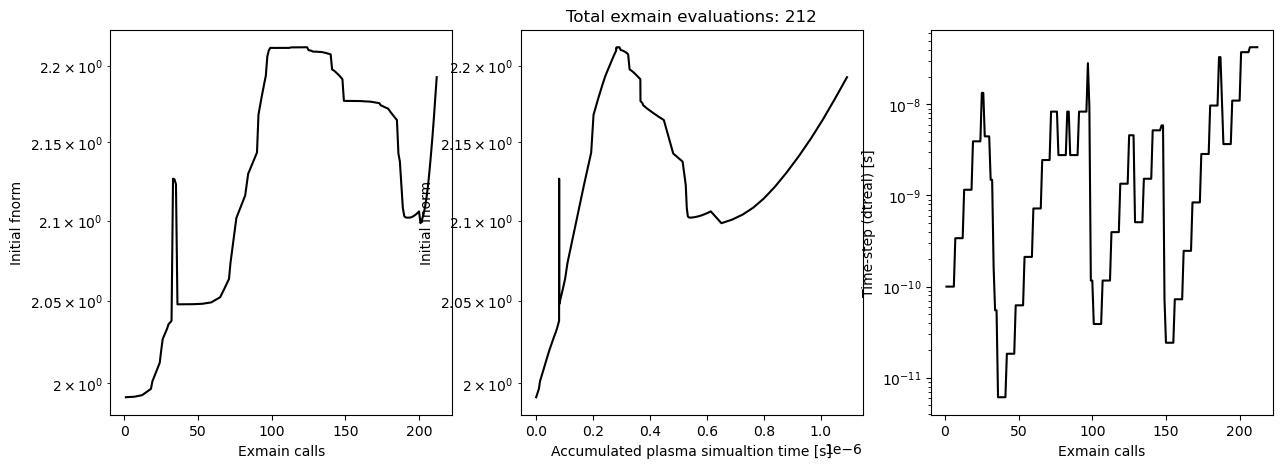

In [13]:
c.solver.convergenceanalysis('reconverged3_v12_p1.45_n2.38_imp8e3_dp0.06_kep0.06_kip0.0226_last_ii2.hdf5');

# Inner plate

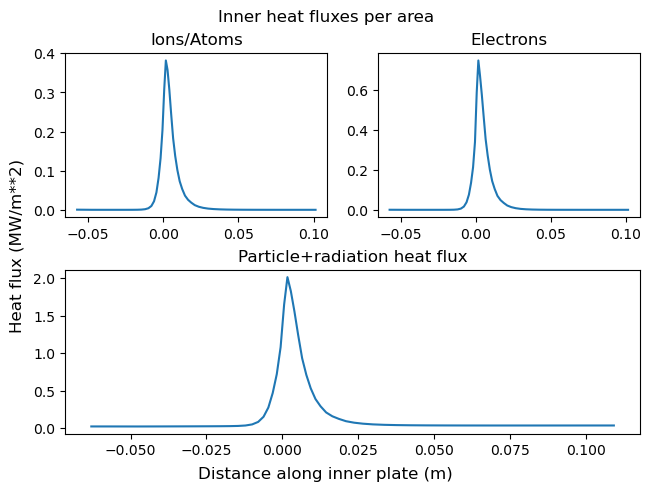

In [22]:
# %matplotlib widget
bbb.fqp=0
bbb.plateflux(); #internally calculated fluxes (postprocessing)

fig, axs = plt.subplot_mosaic(
    [['TopLeft', 'TopRight'],
     ['Bottom', 'Bottom']],
    layout='constrained',  # Automatically adjust layout
    width_ratios=[1, 1],   # Equal width for the top plots
)
fig.suptitle('Inner heat fluxes per area')
fig.supxlabel('Distance along inner plate (m)')
fig.supylabel('Heat flux (MW/m**2)')
# axs['TopRight'].set_xlabel("Distance along inner plate (m)")
#axs['TopRight'].set_ylabel("feex (W)")
axs['TopRight'].set_title("Electrons")
axs['TopRight'].plot(com.yylb[1:-1],bbb.sdelb[1:-1,0]*1e-6)

# axs['TopLeft'].set_xlabel("Distance along inner plate (m)")
# axs['TopLeft'].set_ylabel("Heat flux (MW/m**2)")
axs['TopLeft'].set_title("Ions/Atoms")
axs['TopLeft'].plot(com.yylb[1:-1],bbb.sdilb[1:-1]*1e-6) #polodal east field area

# axs['Bottom'].set_xlabel("Distance along inner plate (m)")
# axs['Bottom'].set_ylabel("Heat flux [MW/m**2]")
axs['Bottom'].set_title("Particle+radiation heat flux")
axs['Bottom'].plot(com.yylb,1.e-6*(bbb.sdtlb+bbb.sdrlb))
plt.show()

# Length Scale Calculations

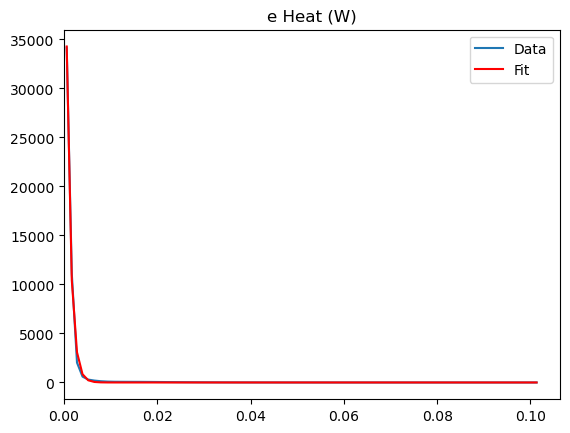

Lambda_q estimate: 0.9157093178092264 mm
99.9% of heat flux at x = 4.211cm, e temp = 3.258 eV
*** at x = 2cm (Index = 5), interpolated Elc temp = 6.784 eV ***
at x = 2.092cm, Elc temp = 6.556 eV
at x = 2.978cm, Elc temp = 4.796 eV
at x = 5.326cm, Elc temp = 2.407 eV


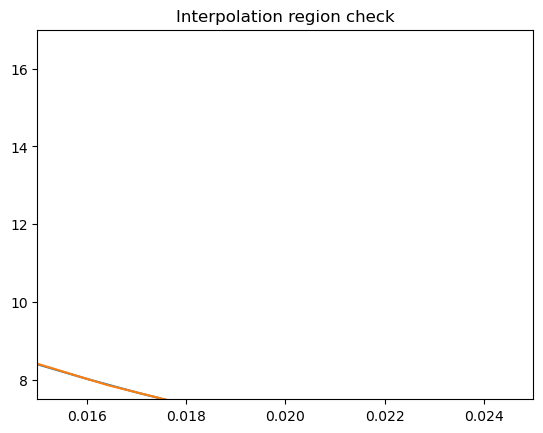

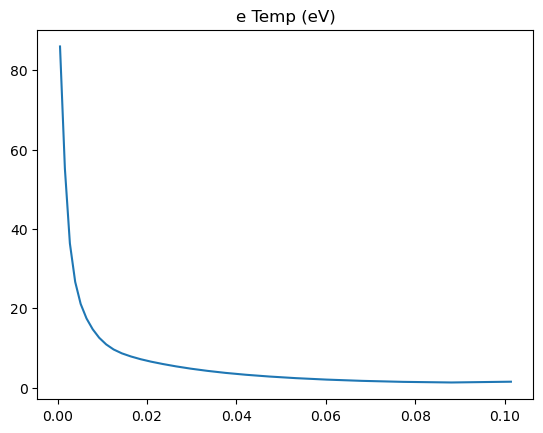

5ev at x = 2.978145458618995cm


In [94]:
#lambda_q from Eich = 1.06mm (we are probably a bit wider, so I am targeting 1.1mm, lambda_t = 3
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline
# NEED: ION HEAT, ELECTRON HEAT, ION DENSITY
poloidal_index = 28 # CHANGE TO 28 for in board, 32 out board
# exponential fit

#ELECTRONS HEAT 
eheat = -np.array(bbb.feex[poloidal_index,1:-1]) #add a minus sign for inboard
dist = np.array([val[0] for val in com.yylb[1:-1]])
mask = dist >= 0
eheat = eheat[mask]
dist = dist[mask]
# Params[0]=a, params[1]=b
# b=-1/lambda_q
params, pcov = curve_fit(lambda t,a,b: a*np.exp(b*t),  dist,  eheat,  p0=(0.5, 1/4))
#print(pcov)
#print(params)
y_fit = params[0]*np.exp(params[1]*dist)
# print(y_fit)
# Plot the results
plt.plot(dist, eheat, label="Data")

plt.title("e Heat (W)")
plt.plot(dist, y_fit, 'r-', label="Fit")
plt.gca().set_xlim(left=0)
# plt.axhline(y=0.0, color='r', linestyle='-')
plt.legend()
# plt.yscale('log')
plt.show()
print(f"Lambda_q estimate: {-1/params[1]*1000} mm")

# calc 99% heat flux
# electron TEMP REGION
from scipy.integrate import simpson
totalheat = simpson(eheat, x=dist)
from scipy.integrate import cumulative_trapezoid
cumulative_integral = cumulative_trapezoid(eheat, dist, initial=0)
target_scale = 0.999
target_value = target_scale * cumulative_integral[-1]
# print("Int check",totalheat,cumulative_integral)

index = np.searchsorted(cumulative_integral, target_value)

decaylen = dist[index]
poloidal_index = 28
etemp= np.array(bbb.te[poloidal_index,1:-1]/bbb.ev)
etemp = etemp[mask]

# Interpolating to get exact temp at wall
interp_func = UnivariateSpline(dist[10:17], etemp[10:17])
x = np.arange(0.015, 0.025, 0.001)
# print(x)
y = interp_func(x)

wallIndex = np.where(abs(x - 0.02) < 0.0000001)[0][0]


# print(np.shape(dist),np.shape(eheat), np.shape(etemp))
print(f"{target_scale*100}% of heat flux at x = {(decaylen*100):.3f}cm, e temp = {etemp[index]:.3f} eV")
print(f"*** at x = 2cm (Index = {wallIndex}), interpolated Elc temp = {y[wallIndex]:.3f} eV ***")
print(f"at x = {(dist[13]*100):.3f}cm, Elc temp = {etemp[13]:.3f} eV")
print(f"at x = {(dist[16]*100):.3f}cm, Elc temp = {etemp[16]:.3f} eV")
print(f"at x = {(dist[21]*100):.3f}cm, Elc temp = {etemp[21]:.3f} eV")
plt.plot(x, y)
plt.plot(dist, etemp)
plt.title('Interpolation region check')
plt.xlim([0.015,0.025])
plt.ylim([7.5,17])
plt.show()
# tparams, tpcov = curve_fit(lambda t,a,b: a*np.exp(b*t),  dist,  etemp,  p0=(0.5, -1))
plt.plot(dist, etemp)
plt.title("e Temp (eV)")
plt.show()
targeteV = 5
eev = np.searchsorted(etemp[::-1], targeteV, side = "right")*-1

print(f"{targeteV}ev at x = {dist[eev]*100}cm")



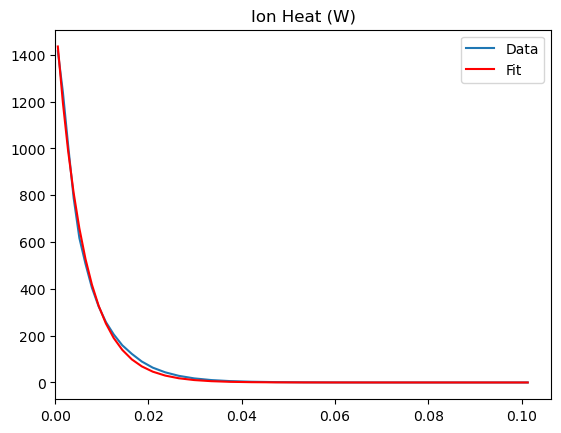

Lambda_q estimate: 5.924327741176883 mm
99.9% of heat flux at x = 4.211cm, Ion temp = 4.367 eV
*** at x = 2cm (Index = 5), interpolated Ion temp = 9.746 eV ***
at x = 2.092cm, Ion temp = 9.229 eV
at x = 2.978cm, Ion temp = 5.797 eV
at x = 5.326cm, Ion temp = 4.154 eV


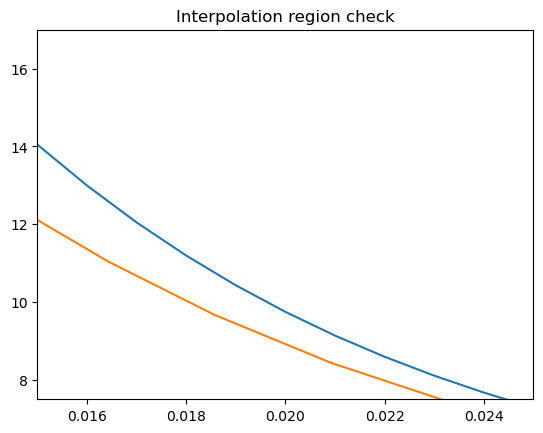

10ev at x = 2.092152644185836cm


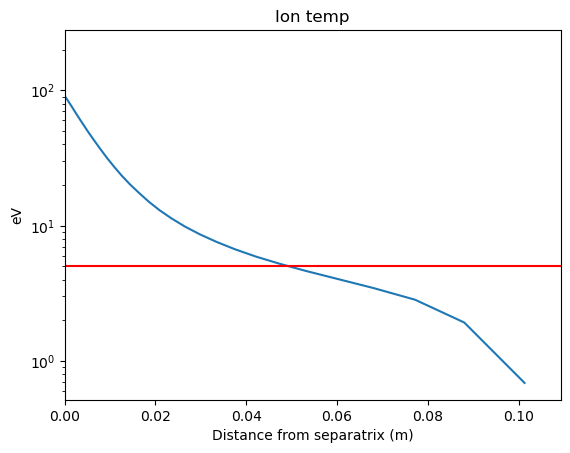

In [24]:
#lambda_q from Eich = 1.06mm (we are probably a bit wider, so I am targeting 1.1mm, lambda_t = 3
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline
# NEED: ION HEAT, ELECTRON HEAT, ION DENSITY
poloidal_index = 28 # CHANGE TO 28 for in board, 32 out board
# exponential fit

# IONS HEAT
ionheat = -np.array(bbb.feix[poloidal_index,1:-1]) #add a minus sign for inboard
dist = np.array([val[0] for val in com.yylb[1:-1]])
mask = dist >= 0
ionheat = ionheat[mask]
dist = dist[mask]
# Params[0]=a, params[1]=b
# b=-1/lambda_q
params, pcov = curve_fit(lambda t,a,b: a*np.exp(b*t),  dist,  ionheat,  p0=(0.5, -1))
#print(pcov)
#print(params)
y_fit = params[0]*np.exp(params[1]*dist)
# print(y_fit)
# Plot the results
plt.plot(dist, ionheat, label="Data")
plt.title("Ion Heat (W)")
plt.plot(dist, y_fit, 'r-', label="Fit")
plt.gca().set_xlim(left=0)
# plt.axhline(y=0.0, color='r', linestyle='-')
plt.legend()
plt.show()
print(f"Lambda_q estimate: {-1/params[1]*1000} mm")

# ION TEMP REGION
from scipy.integrate import simpson
totalheat = simpson(ionheat, x=dist)
from scipy.integrate import cumulative_trapezoid
cumulative_integral = cumulative_trapezoid(ionheat, dist, initial=0)
target_scale = 0.999
target_value = target_scale * totalheat
iontemp= np.array(bbb.ti[poloidal_index,1:-1]/bbb.ev)
iontemp = iontemp[mask]


# Interpolation check
interp_func = UnivariateSpline(dist[10:17], iontemp[10:17])
x = np.arange(0.015, 0.025, 0.001)
# print(x)
y = interp_func(x)

wallIndex = np.where(abs(x - 0.02) < 0.0000001)[0][0]


index = np.searchsorted(cumulative_integral, target_value)
# print("HI",dist[13])
decaylen = dist[index]
poloidal_index = 29
iontemp= np.array(bbb.ti[poloidal_index,1:-1]/bbb.ev)
iontemp = iontemp[mask]
print(f"{target_scale*100}% of heat flux at x = {(decaylen*100):.3f}cm, Ion temp = {iontemp[index]:.3f} eV")
print(f"*** at x = 2cm (Index = {wallIndex}), interpolated Ion temp = {y[wallIndex]:.3f} eV ***")
print(f"at x = {(dist[13]*100):.3f}cm, Ion temp = {iontemp[13]:.3f} eV")
print(f"at x = {(dist[16]*100):.3f}cm, Ion temp = {iontemp[16]:.3f} eV")
print(f"at x = {(dist[21]*100):.3f}cm, Ion temp = {iontemp[21]:.3f} eV")
# tparams, tpcov = curve_fit(lambda t,a,b: a*np.exp(b*t),  dist,  iontemp,  p0=(0.5, -1))
plt.plot(x, y)
plt.plot(dist, etemp)
plt.title('Interpolation region check')
plt.xlim([0.015,0.025])
plt.ylim([7.5,17])
plt.show()
targeteV = 10
iev = np.searchsorted(iontemp[::-1], targeteV, side = "right")*-1

print(f"{targeteV}ev at x = {dist[iev]*100}cm")
plt.xlabel("Distance from separatrix (m)")
plt.ylabel("eV")
plt.title("Ion temp")
plt.plot(com.yylb[1:-1],bbb.ti[34,1:-1]/bbb.ev)
plt.axhline(y=5, color='r', linestyle='-')
plt.gca().set_xlim(left=0)
plt.yscale('log') 
plt.show()



# Midplane

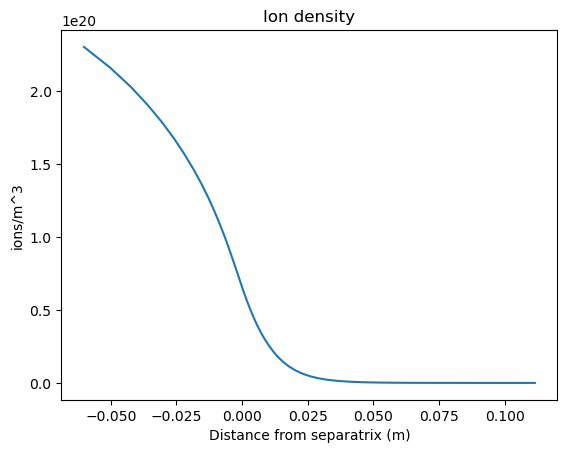

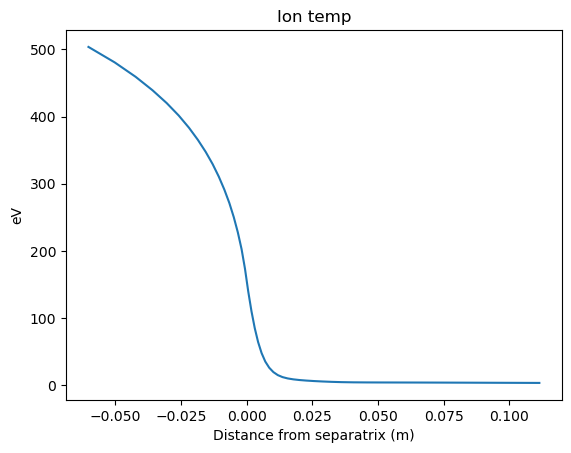

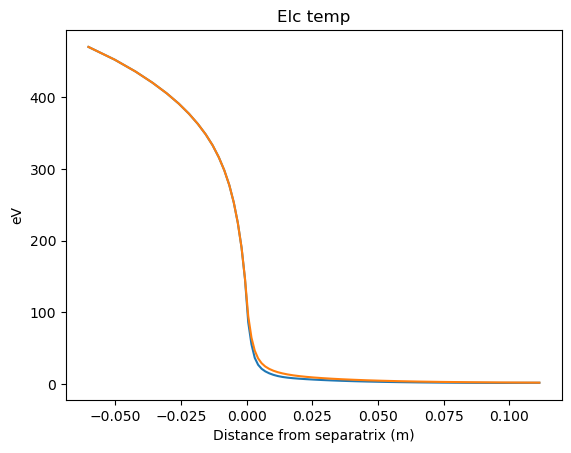

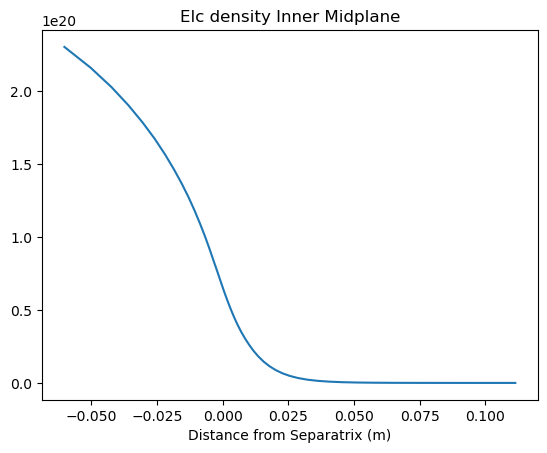

Text(0.5, 1.0, 'Elc density Outer Midplane')

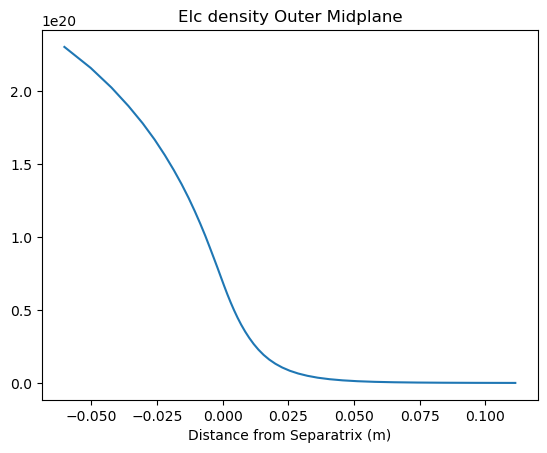

In [47]:
# %matplotlib widget
plt.xlabel("Distance from separatrix (m)")
plt.ylabel("ions/m^3")
plt.title("Ion density")
plt.plot(com.yylb[1:-1],bbb.ni[28,1:-1,0])
plt.show()
plt.xlabel("Distance from separatrix (m)")
plt.ylabel("eV")
plt.title("Ion temp")
plt.plot(com.yylb[1:-1],bbb.ti[28,1:-1]/bbb.ev)
plt.show()
plt.xlabel("Distance from separatrix (m)")
plt.ylabel("eV")
plt.title("Elc temp")
plt.plot(com.yylb[1:-1],bbb.te[28,1:-1]/bbb.ev)
plt.plot(com.yylb[1:-1],bbb.te[31,1:-1]/bbb.ev)
plt.show()

plt.plot(com.yylb[1:-1], bbb.ne[30,1:-1])
plt.xlabel('Distance from Separatrix (m)')
plt.title('Elc density Inner Midplane')
plt.show()
plt.plot(com.yylb[1:-1], bbb.ne[31,1:-1])
plt.xlabel('Distance from Separatrix (m)')
plt.title('Elc density Outer Midplane')
#inner limit of dist. from separatrix should correspond with the rho coord of temp and n BC so rho * minor rad. (0.72m)
#rho=0.92


In [173]:
rho = (com.yylb[1:-1] / 0.72) + 1
n_e = bbb.ne[31,1:-1].reshape(44)
rho = rho.reshape(44)
np.savetxt('midplane_ne.csv', np.vstack((rho,n_e)).T, delimiter=', ')
t_i = bbb.ti[31,1:-1].reshape(44)
t_e = bbb.te[31,1:-1].reshape(44)
np.savetxt('midplane_ti.csv', np.vstack((rho,t_i)).T, delimiter=', ')
np.savetxt('midplane_te.csv', np.vstack((rho,t_e)).T, delimiter=', ')

# Outer plate

<Figure size 640x480 with 0 Axes>

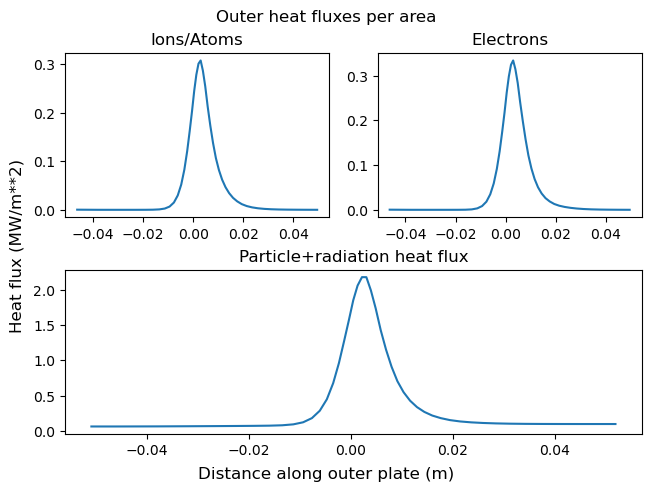

array([2.177799])

In [73]:
# total convective and conductive heat flux
# 2nd char: e for energy n for particle
bbb.fqp=0
bbb.plateflux(); #internally calculated fluxes (postprocessing)

plt.figure()
fig, axs = plt.subplot_mosaic(
    [['TopLeft', 'TopRight'],
     ['Bottom', 'Bottom']],
    layout='constrained',  # Automatically adjust layout
    width_ratios=[1, 1],   # Equal width for the top plots
)
fig.suptitle('Outer heat fluxes per area')
fig.supxlabel('Distance along outer plate (m)')
fig.supylabel('Heat flux (MW/m**2)')
# axs['TopRight'].set_xlabel("Distance along inner plate (m)")
#axs['TopRight'].set_ylabel("feex (W)")
axs['TopRight'].set_title("Electrons")
axs['TopRight'].plot(com.yyrb[1:-1],bbb.sderb[1:-1,0]*1e-6)

# axs['TopLeft'].set_xlabel("Distance along inner plate (m)")
# axs['TopLeft'].set_ylabel("Heat flux (MW/m**2)")
axs['TopLeft'].set_title("Ions/Atoms")
axs['TopLeft'].plot(com.yyrb[1:-1],bbb.sdirb[1:-1,0]*1e-6) #polodal east field area


# axs['Bottom'].set_xlabel("Distance along inner plate (m)")
# axs['Bottom'].set_ylabel("Heat flux [MW/m**2]")
axs['Bottom'].set_title("Particle+radiation heat flux")
axs['Bottom'].plot(com.yyrb,1.e-6*(bbb.sdtrb+bbb.sdrrb))
plt.show()
max(1.e-6*(bbb.sdtrb+bbb.sdrrb))

In [80]:
np.sum( (bbb.sdtrb+bbb.sdrrb)) / 1e6

np.float64(25.673051490542424)

2 64


0.0

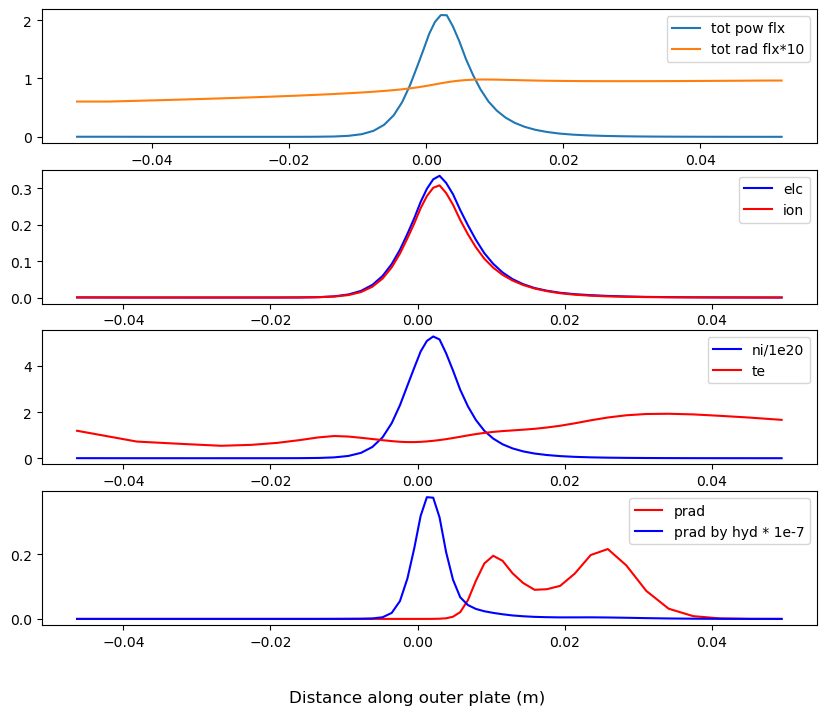

In [85]:
fig, axs = plt.subplots(4, figsize=(10,8))
fig.supxlabel('Distance along outer plate (m)')
bbb.fqp=0
bbb.plateflux(); #internally calculated fluxes (postprocessing)
x = com.yyrb[1:-1]
axs[0].plot(com.yyrb,1.e-6*bbb.sdtrb, label='tot pow flx')
axs[0].plot(com.yyrb,1.e-6*bbb.sdrrb*10, label='tot rad flx*10')
axs[0].legend()
# axs[0].plot(com.yylb,1.e-6*bbb.sbindrb)
axs[1].plot(x, bbb.sderb[1:-1]*1e-6, '-b', label='elc')
axs[1].plot(x, bbb.sdirb[1:-1]*1e-6, '-r', label='ion')
print(com.nisp,com.nx)
# axs[2].plot(x, bbb.engirb[1:com.ny+1,com.nisp-1,com.nxpt-1], '--r', label='ave ion energy')
# axs[2].plot(com.yylb, bbb.pwr_pltz[0:ny+1,2*nxpt), '--b', label='rad')
axs[1].legend()
axs[2].plot(x, bbb.ni[com.nx+1,1:-1,0]/1e20, '-b', label='ni/1e20')
axs[2].plot(x, bbb.te[com.nx+1,1:-1]/bbb.ev, '-r', label='te')
axs[2].legend()
axs[3].plot(x, bbb.prad[com.nx+1,1:-1], '-r', label='prad')
axs[3].plot(x, bbb.pradhyd[com.nx+1,1:-1]/1e7, '-b', label='prad by hyd * 1e-7')
axs[3].legend()
bbb.pradht

# 2D Plots


<Figure size 640x480 with 0 Axes>

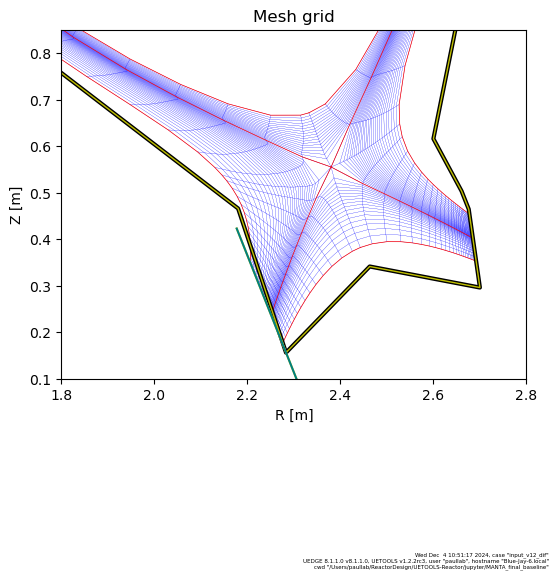

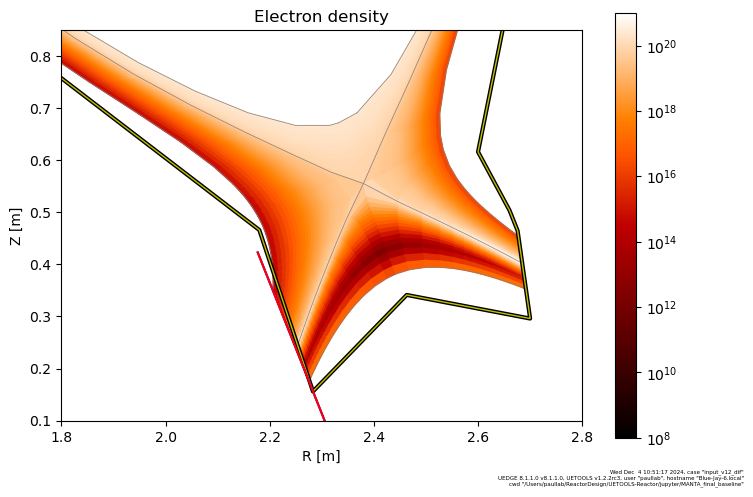

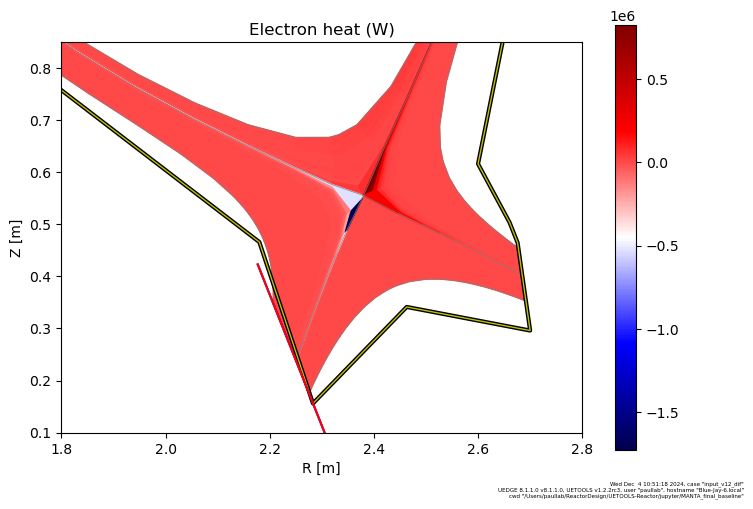

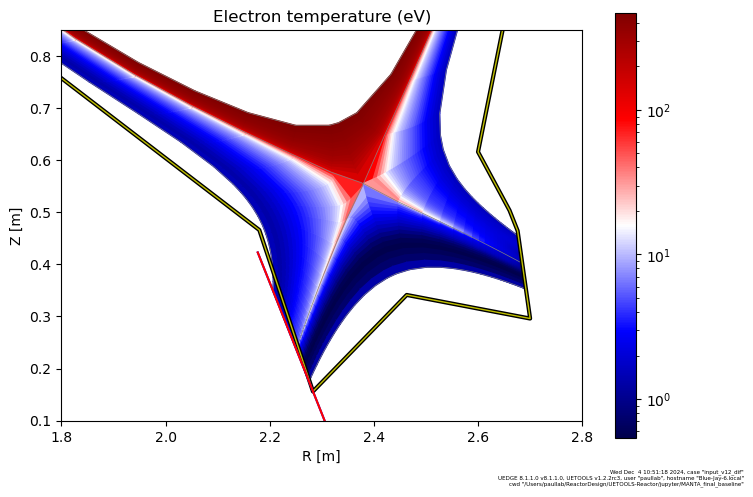

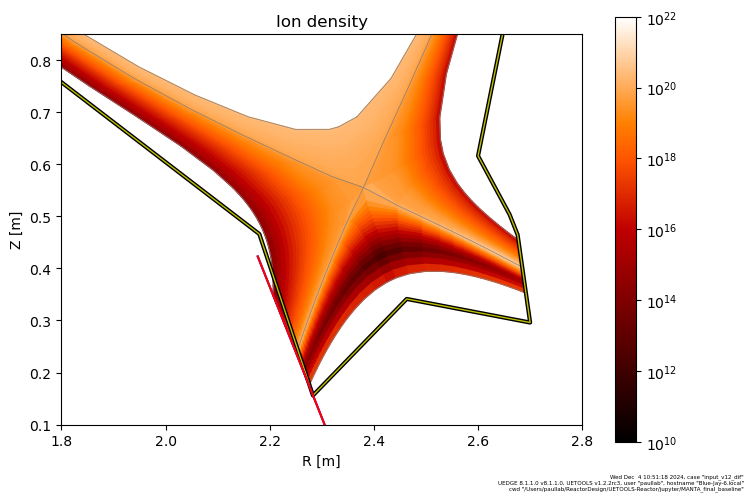

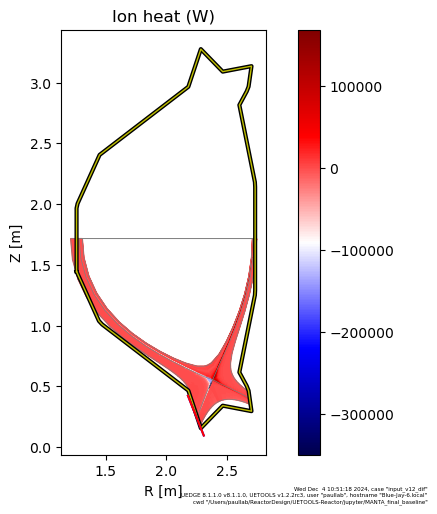

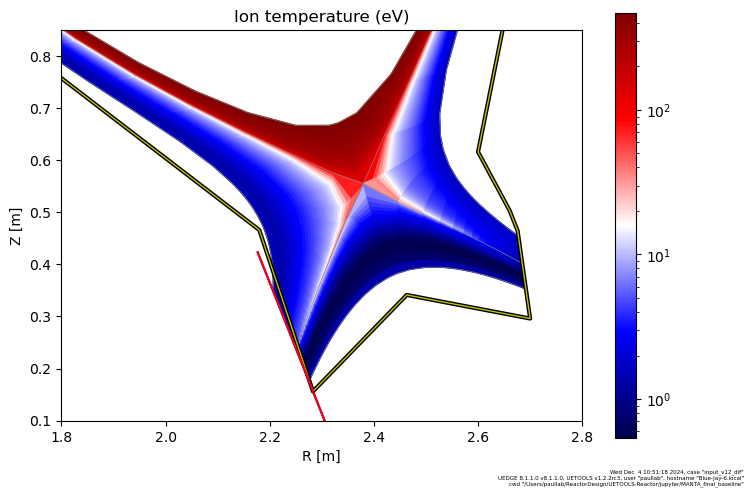

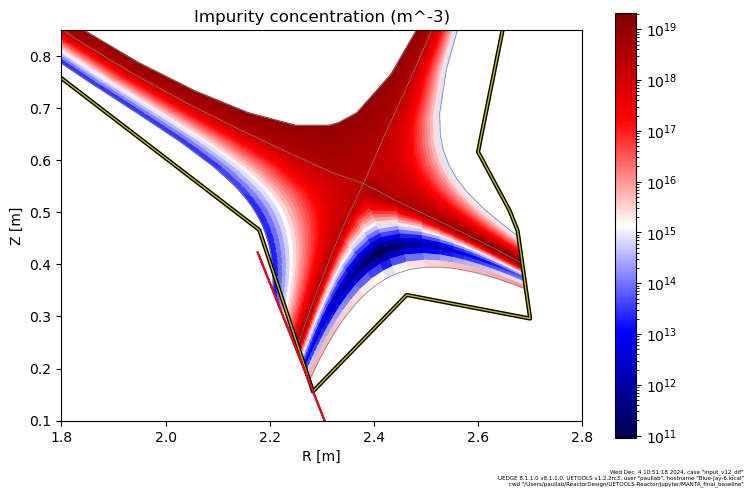

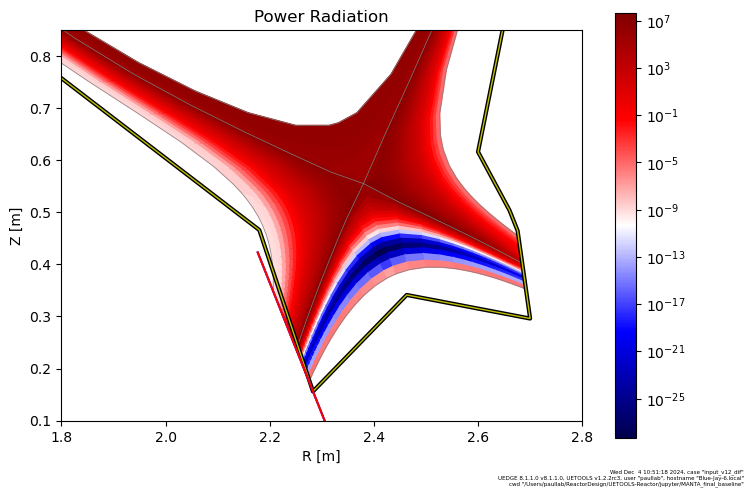

In [62]:
plt.figure()

c.plot.grid(linewidth=0.1, #grid plot
   vessel=True, 
   plates=True, 
   platecolor=['gold','teal'], 
   lcfs=True, 
   xlim=(1.8, 2.8), 
   ylim=(0.1,0.85),
   lcfscolor='r', 
   linecolor='b',
   title='Mesh grid'
  );

c.plot.mesh(
    bbb.ne, 
    log=True, 
    xlim=(1.8, 2.8), 
    ylim=(0.1,0.85),
    figsize=(7,5), 
    zrange=(1e8,1e21), 
    cmap='gist_heat',
    title='Electron density'
);


c.plot.mesh(
    bbb.feex, 
    xlim=(1.8, 2.8), 
    ylim=(0.1,0.85), 
    figsize=(7,5), 
    # zrange=(-8e5,8e5),
    cmap='seismic',
    title='Electron heat (W)'
);
c.plot.mesh(
    bbb.te/bbb.ev, 
    log=True, 
    xlim=(1.8, 2.8), 
    ylim=(0.1,0.85), 
    figsize=(7,5), 
    # zrange=(-5e5,5e5),
    cmap='seismic',
    title='Electron temperature (eV)'
);

c.plot.mesh(
    bbb.ne, 
    log=True, 
    xlim=(1.8, 2.8), 
    ylim=(0.1,0.85),
    figsize=(7,5), 
    zrange=(1e10,1e22), 
    cmap='gist_heat',
    title='Ion density'
);
c.plot.mesh(
    bbb.feix, 
    # xlim=(1.8, 2.8), 
    # ylim=(0.1,0.85),
    figsize=(7,5), 
    # zrange=(-8e5,8e5),
    cmap='seismic',
    title='Ion heat (W)'
);
c.plot.mesh(
    bbb.te/bbb.ev, 
    log=True, 
    xlim=(1.8, 2.8), 
    ylim=(0.1,0.85), 
    figsize=(7,5), 
    # zrange=(-5e5,5e5),
    cmap='seismic',
    title='Ion temperature (eV)'
);
c.plot.mesh(
    bbb.na, 
    log=True, 
    xlim=(1.8, 2.8), 
    ylim=(0.1,0.85), 
    figsize=(7,5), 
    # zrange=(-5e5,5e5),
    cmap='seismic',
    title='Impurity concentration (m^-3)'
);
c.plot.mesh(
    bbb.prad, 
    log=True, 
    xlim=(1.8, 2.8), 
    ylim=(0.1,0.85), 
    figsize=(7,5), 
    # zrange=(-5e5,5e5),
    cmap='seismic',
    title='Power Radiation'
);
plt.show()

In [15]:
c.dashboard() # a GUI with all the most common variable

2024-12-03 17:38:59.660 python[30589:1509532] +[IMKClient subclass]: chose IMKClient_Modern
2024-12-03 17:38:59.660 python[30589:1509532] +[IMKInputSession subclass]: chose IMKInputSession_Modern


## Zeff

In [ ]:
nD = bbb.ni.transpose()
nT = nD[1]
nD = nD[0]
nT = nT.transpose()
nD = nD.transpose()
zeff = (nT+nD+(bbb.na*10))/bbb.ne
c.plot.mesh(
    zeff, 
    log=True, 
    xlim=(1.8, 2.8), 
    ylim=(0.1,0.85), 
    figsize=(7,5), 
    zrange=(1,10),
    cmap='seismic',
    title='Impurity concentration (m^-3)'
);
zeff

In [ ]:
y = zeff[17:41,2]
plt.plot(y)
plt.show()
y

# Power Calculations

In [14]:
c = Case('reconverged_v12_p3.93_n2.38_imp5e3_dp0.06_kep0.06_kip0.06_last_ii2.hdf5')

Restoring case from HDF5 file:
  Rate dirs read from .uedgerc
  Grid read from .../jupyter/MANTA_final_baseline/reconverged_v12_p3.93_n2.38_imp5e3_dp0.06_kep0.06_kip0.06_last_ii2.hdf5
  User-specified diffusivities read from HDF5 file ".../jupyter/MANTA_final_baseline/reconverged_v12_p3.93_n2.38_imp5e3_dp0.06_kep0.06_kip0.06_last_ii2.hdf5"
UETOOLS-style save successfully restored from .../jupyter/MANTA_final_baseline/reconverged_v12_p3.93_n2.38_imp5e3_dp0.06_kep0.06_kip0.06_last_ii2.hdf5
*** For isimpon=2, set afracs, not afrac ***

*** UEDGE arrays populated: Warning, case may noy be fully converged ***
fnrm without preconditioning: 94.4



In [84]:
from scipy.integrate import simpson
bbb.fqp=0
bbb.plateflux();

psep = simpson( (bbb.feiy+bbb.feey)[com.ixpt1[0]+1:com.ixpt2[0],com.iysptrx]) / 1e6
pcore = simpson( (bbb.feiy+bbb.feey)[com.ixpt1[0]+1:com.ixpt2[0],0]) / 1e6

print(f' Power from core boundary (surface closest to magnetic axis) = {pcore:.3f} MW  \n \
Power at Separatrix = {psep:.3f} MW  \n \
Power radiated in core region = {(pcore-psep):.3f} MW = {((abs(pcore-psep)/pcore)*100):3f}%')
particlecore = simpson( (bbb.fniy)[com.ixpt1[0]+1:com.ixpt2[0],0])

 Power from core boundary (surface closest to magnetic axis) = 7.883 MW  
 Power at Separatrix = 4.093 MW  
 Power radiated in core region = 3.790 MW = 48.082053%


In [ ]:
impFracs = [1e-4, 3e-3, 3e-2]
pRads = [33.11, 33.9, 42.5]

In [24]:
c.search.var("dif_use")
c.search.var("up")
# bbb.turb_chi()
bbb.up

Package:    bbb
Group:      Conduc
Attributes: Conduc input 
Dimension:  (0:nx+1,0:ny+1,1:nisp)
            (66, 46, 2)
Type:       double
Address:    4434952192
Pyaddress:  5968645072
Unit:       m**2/s
Comment:
spatially depend. diff; if
isbohmcalc=1, user input if all
facbni+facbup+facbee+facbei =0,
or kybohm if facbni, etc. > 0;
if isbohmcalc=2, then
D = difni*kybohm/(difni+kybohm)
Package:    bbb
Group:      Compla
Attributes: Compla 
Dimension:  (0:nx+1,0:ny+1,1:nisp)
            (66, 46, 2)
Type:       double
Address:    5547458560
Pyaddress:  4944570448
Unit:       m/s
Comment:
par ion vel if full mom eqn on
(mass-dens. avg if isimpon = 5)


array([[[-10288.84789411, -10805.17396601],
        [-11337.01923875, -10770.16827682],
        [-11282.50800856, -10718.38260813],
        ...,
        [-15312.11860408, -14546.51267387],
        [-15309.70604886, -14544.22074642],
        [-15657.36064141, -14540.72573137]],

       [[ -9240.67654946, -10840.1796552 ],
        [-11007.79629914, -10826.78258736],
        [-10832.76005854, -10940.25951686],
        ...,
        [-15309.3419796 , -14544.1396632 ],
        [-15309.38695942, -14540.01998173],
        [-16005.01523396, -14537.23071631]],

       [[ -9241.62764731, -11186.53861951],
        [-10797.91920438, -11259.51381875],
        [-10603.26526975, -11603.55077701],
        ...,
        [-15299.22580127, -14540.48200671],
        [-15307.99786656, -14535.82800395],
        [-15967.16480059, -14533.30212853]],

       ...,

       [[  7881.45286319,   9839.25146742],
        [  9931.33588392,   9775.9377439 ],
        [  9131.68421069,   8996.64096185],
        ...,
     

In [33]:
len(bbb.te[28])

46